# Lecture 17 : GPU Harmonic Sum

# Part 1 : Harmonic Series

## We learned in calculus that the harmonic series diverges to $\infty$.  
## $$S = \displaystyle\sum_{i=1}^{\infty} \frac{1}{i}$$
## In this lecture we will calculate the partial sum
## $$S = \displaystyle\sum_{i=1}^{N} \frac{1}{i}$$
## There is no exact formula for verifying our answers.
## We can use a sequential implementation to check our work.  

In [16]:
%%writefile harmonic.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

typedef unsigned long long int uint64;

int main(int argc, char** argv) {

    // get N from command line
    if (argc != 2) {
	    printf ("Command usage : %s %s\n",argv[0],"N");
	    return 1;
    }
    uint64 N = atoll(argv[1]);

    // start the timer
    clock_t start = clock();

    // calculate sum
    double sum = 0;
    for (uint64 i = 1; i <= N; i++) {
	    sum += 1.0/i;
    }

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // print results
    printf ("sum = %.5f\n",sum);
    printf ("elapsed time = %.2f seconds\n",elapsed);
}


Overwriting harmonic.c


## Let's compile the sequential code with optimization flags *-O3* turned on.

In [17]:
!gcc -O3 -o harmonic harmonic.c

## N = 1 billion

In [18]:
!./harmonic 1000000000

sum = 21.30048
elapsed time = 1.75 seconds


## N = 10 billion

In [19]:
!./harmonic 10000000000

sum = 23.60307
elapsed time = 15.96 seconds


## N = 100 billion

In [22]:
!./harmonic 100000000000

sum = 25.90565
elapsed time = 161.27 seconds


## N = 1 trillion

In [23]:
!./harmonic 1000000000000

sum = 28.20824
elapsed time = 1613.94 seconds


## The A100 GPU is well suited for double precision arithmetic.
## We have access to A100s on ARC.
## Here are some runs on the A100 where we calculate the harmonic sum.

    [jasonwil@tc-dgx001 gpu]$ nvcc -arch=sm_80 -o gpu_harmonic gpu_harmonic.cu
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 1000000000 256 10000
    sum = 21.30048
    elapsed time = 0.00 seconds
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 10000000000 256 10000
    sum = 23.60307
    elapsed time = 0.02 seconds
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 100000000000 256 10000
    sum = 25.90565
    elapsed time = 0.17 seconds
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 1000000000000 256 10000
    sum = 28.20824
    elapsed time = 1.44 seconds
    [jasonwil@tc-dgx001 gpu]$

## Note that speedup for N equal to 1 trillion is
## $$\text{speedup} = \displaystyle\frac{\text{Sequential Time}}{\text{A100 GPU Time}} = \displaystyle\frac{1613.94}{1.44} = 1121$$
## The GPU is over 1100 times faster than the CPU for this problem!

## The ARC supercomputer Tinkercliffs has 10 DGX A100 servers each with 8 A100 GPUs.

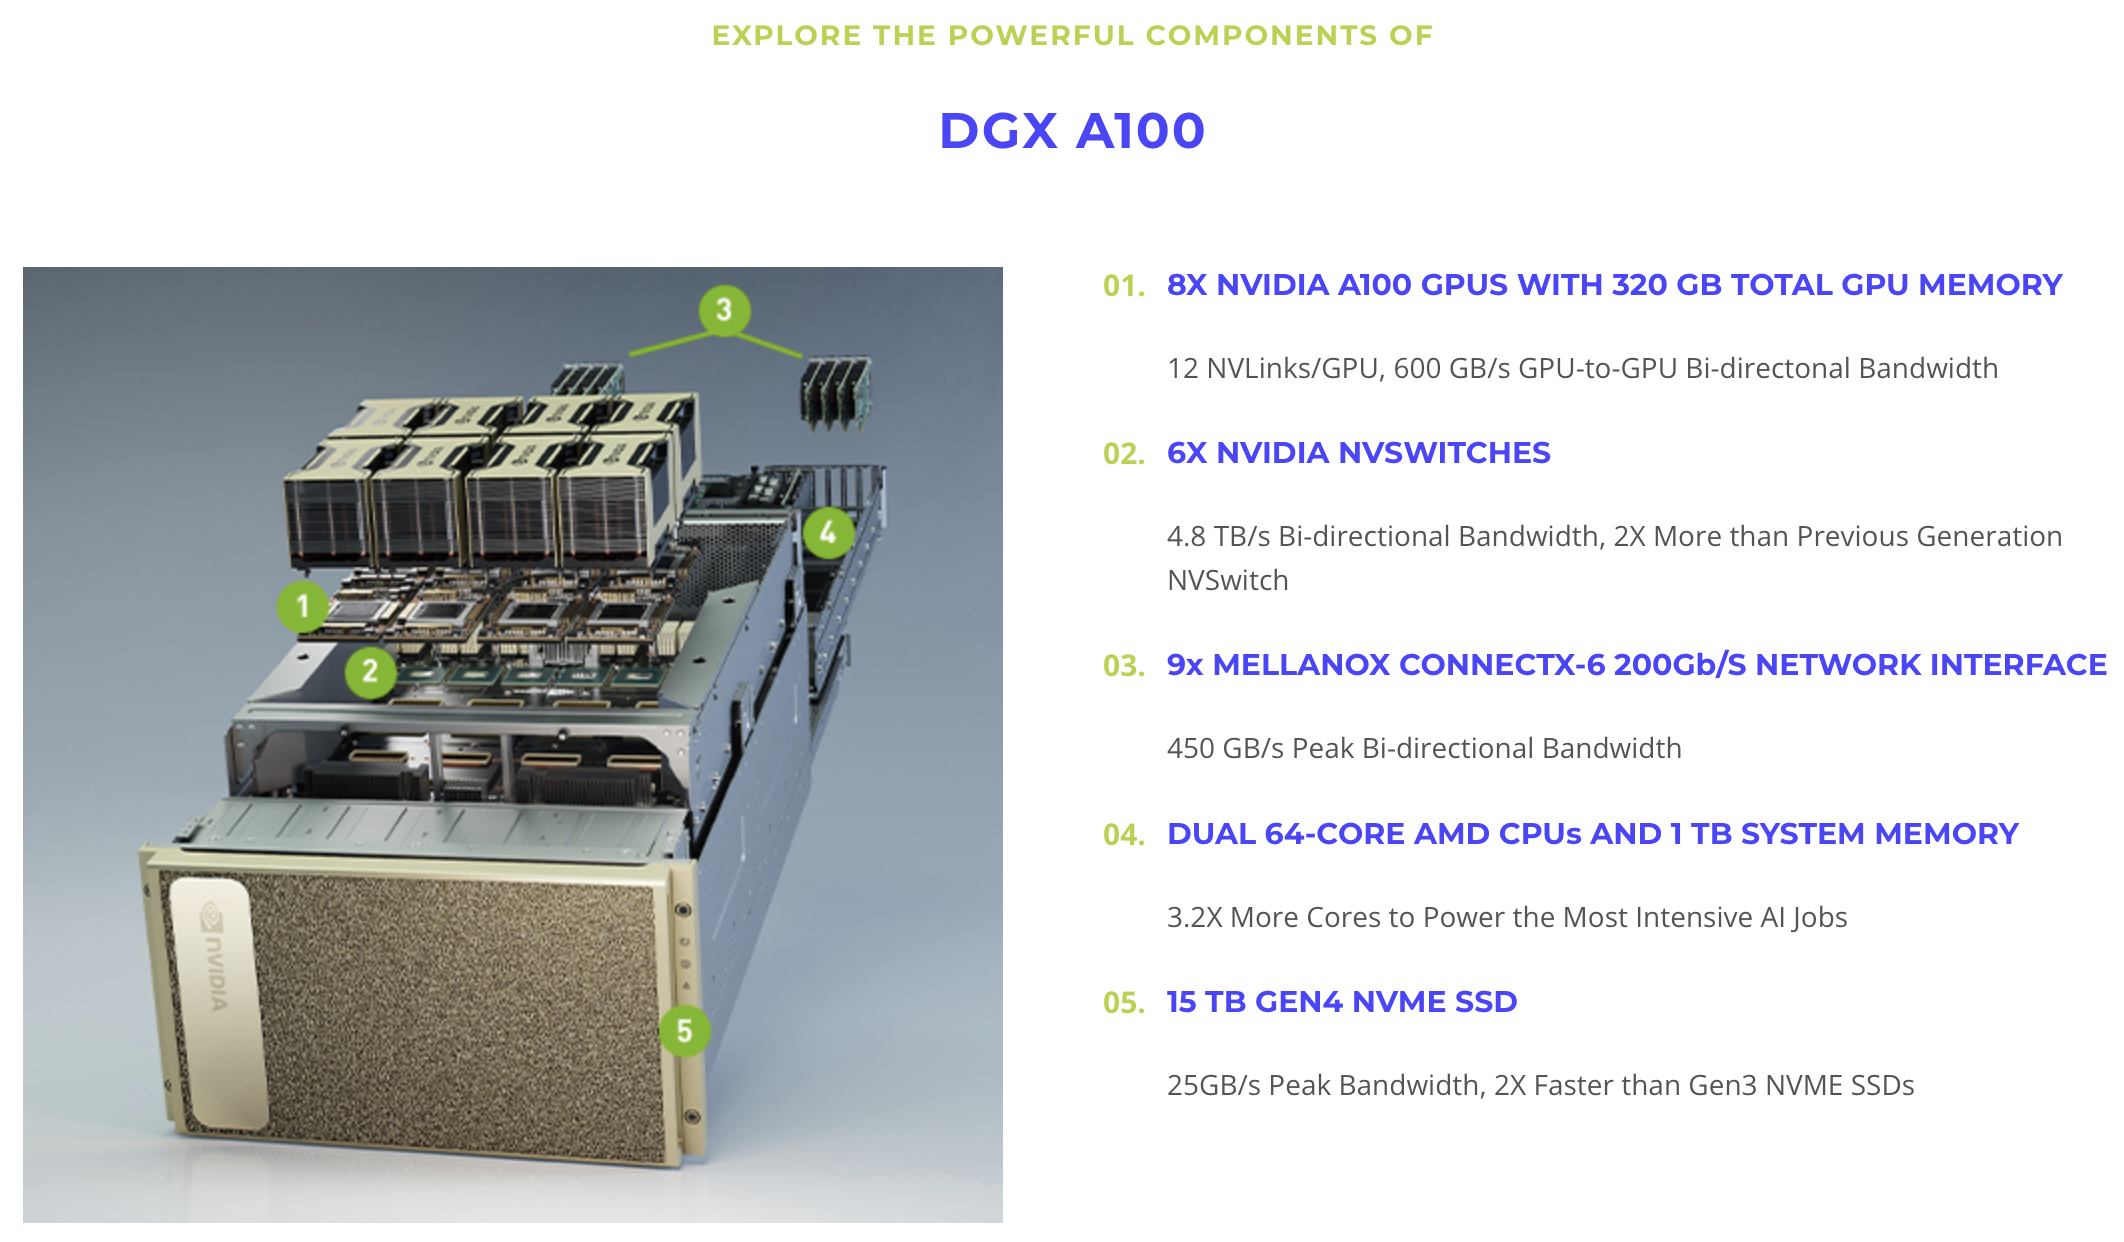




# Part 2 : A Single Thread Block
## Here is our first GPU version to compute $S$ that uses a single thread block.

In [1]:
%%writefile gpu_harmonic_v1.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N) {

    __shared__ double sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    // thread 0 initializes sum to 0
    if (thread_num == 0) {
        sum = 0;
    }
    __syncthreads();

    // calculate the sum
    double thread_sum = 0;
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        thread_sum += 1.0/i;
    }
    atomicAdd(&sum,thread_sum);
    __syncthreads();

    // thread 0 prints the sum
    if (thread_num == 0) {
        printf ("sum = %.5f\n",sum);
    }

}

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }
    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    printf ("number of threads = %d\n",num_threads);

    // start the timer
    clock_t start = clock();

    // launch kernel
    sumKernel <<< 1, num_threads >>> (N);
    cudaDeviceSynchronize();

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // print timing result
    printf ("elapsed time = %.2f seconds\n",elapsed);

}

Writing gpu_harmonic_v1.cu


In [2]:
!nvcc -arch=sm_75 -o gpu_harmonic_v1 gpu_harmonic_v1.cu

In [3]:
!./gpu_harmonic_v1 1000000000 512

number of threads = 512
sum = 21.30048
elapsed time = 2.33 seconds


# Part 2 : Returning the Result

## One downside of version 1 is that the kernel has to print the result.

## Suppose we want our kernel to return the result instead.

## Since CUDA kernels always have a return type of *void*, we must return the result using a pointer.

## Things get a bit complicated however since the CPU (host) and GPU (device) use different memory!

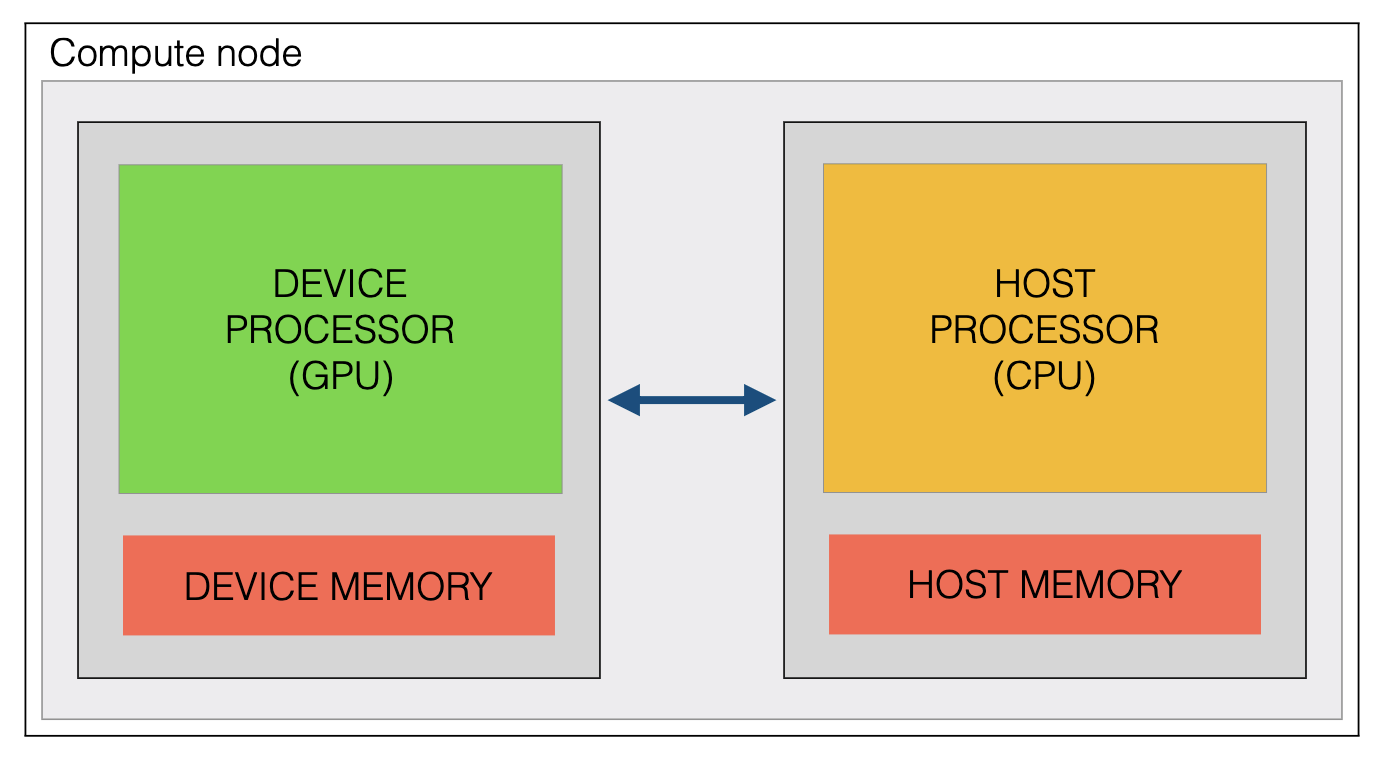

## **Kernel code runs on the GPU (device) and the main function runs on the CPU (host).**

## It is not possible for a thread running on the GPU to read from or write to CPU memory.

## Thus, a thread cannot use a pointer to write the return value to a variable stored in CPU memory.

## A thread running on the device (GPU) can only access device memory.  

## The host (CPU) can access host memory and also allocate and access device memory using special CUDA functions such as cudaMalloc, cudaMemcpy, cudaFree, etc.

## The host has to allocate device memory for the sum variable where thread 0 can write the final sum.

## This device memory allocation of the sum variable is done using **cudaMalloc**.  

## Note the corresponding call to **cudaFree**.

## After the threads finish calculating the sum and thread 0 writes the result to the sum variable stored in device memory, the host copies the device sum variable to a host version of the sum variable using **cudaMemcpy**.  

## Note that the cudaMemcpy call after the kernel launch also synchronizes the device and so we can delete the function call *cudaDeviceSynchronize()* in this version.

## Here is version 2 of our GPU harmonic sum program that uses the above ideas to return the result of summing the harmonic series from the GPU to the CPU.

## Note that in version 2 both **sum** and ***d_sum** are shared variables.  

## **There is one copy of sum per thread block that all threads in the thread block share.**

## **There is only one copy of *d_sum for all threads running on the GPU to share**.

## We call shared variables like sum block-level shared variables.

## We call shared variables like *d_sum global shared variables.

## This distinction will be critical when we have multiple thread blocks!

In [1]:
%%writefile gpu_harmonic_v2.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

typedef unsigned long long int uint64;

// note that d_sum is a pointer to the final sum stored in device memory
__global__ void sumKernel(uint64 N, double* d_sum) {

    __shared__ double sum;

    int thread_num = threadIdx.x;
    int num_threads = blockDim.x;

    // thread 0 initializes sum to 0
    if (thread_num == 0) {
        sum = 0;
    }
    __syncthreads();

    // calculate the sum
    double thread_sum = 0;
    for (uint64 i = 1+thread_num; i <= N;i+=num_threads) {
        thread_sum += 1.0/i;
    }
    atomicAdd(&sum,thread_sum);
    __syncthreads();

    // thread 0 writes the final answer to *d_sum in device memory
    if (thread_num == 0) {
        *d_sum = sum;
    }

}

int main (int argc, char** argv) {

    // get N and num_threads from the command line
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","num_threads");
        return 1;
    }
    uint64 N = atoll(argv[1]);
    int num_threads = atoi(argv[2]);
    printf ("number of threads = %d\n",num_threads);

    // the computed sum in device memory
    double* d_sum;
    cudaMalloc (&d_sum,sizeof(double));

    // start the timer
    clock_t start = clock();

    // launch kernel
    sumKernel <<< 1, num_threads >>> (N,d_sum);

    // copy sum from device to host
    double h_sum;
    cudaMemcpy (&h_sum, d_sum, sizeof(double), cudaMemcpyDeviceToHost);

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // the host prints the final result and elapsed time
    printf ("sum = %.5f\n",h_sum);
    printf ("elapsed time = %.2f seconds\n",elapsed);

    // free the memory for sum on the device
    cudaFree (d_sum);

}

Writing gpu_harmonic_v2.cu


In [2]:
!nvcc -arch=sm_75 -o gpu_harmonic_v2 gpu_harmonic_v2.cu

In [5]:
!./gpu_harmonic_v2 1000000000 512

number of threads = 512
sum = 21.30048
elapsed time = 2.52 seconds


# Part 3 : Multiple Thread Blocks

## Discussion: What is the downside of using a single thread block?

## Hint: All threads in the same thread block have to run on the same SM.

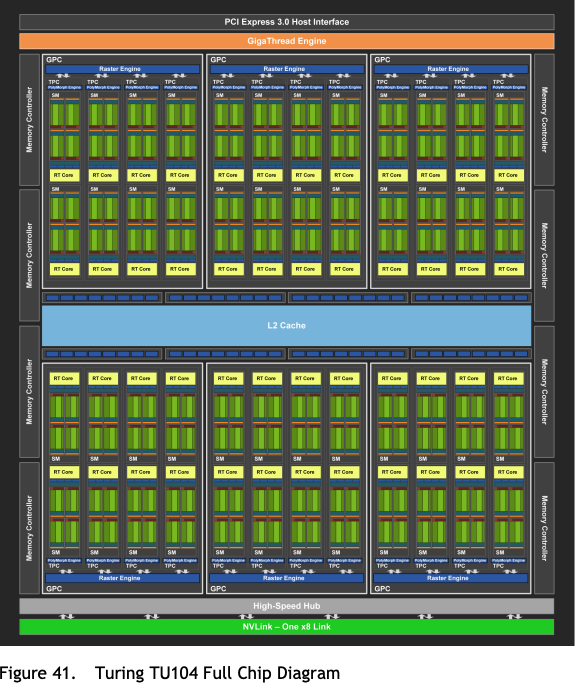

## Answer: Since all threads in the same thread block have to run on a single SM, only one SM is used for the calculation if we use a single thread block.

## Since the T4 has 40 SMs, this means that we are idling 39 out of 40 of the SMs!

## **Thus, with a single thread block we are only using 2.5% of the GPUs total compute power.**

## **To unleash the full power of the GPU we will have to break out of our loop centric view of parallel computing which served us so well with OpenMP.**

# How do we unleash the full power of the GPU?  

## We will need to use more than one thread block in order to make use of every SM on the GPU.  

## This will require us to use substantially more threads.  

## Question: What is the smallest amount of work we can assign to each thread?  

## For example, if we have 10000 dishes to wash what is the smallest amount of work we could have each dishwasher do?  How many dishwashers would we need in this case?

## Answer: Compute a single term 1/i and add it to the final result!

## Question: If we want to have each thread add a single term to the result, how many threads will we need if N is 1 billion?

## Answer: 1 billion threads!

## In OpenMP we normally want each thread to run on a separate CPU core.  

## Thus the number of OpenMP threads is normally set to the number of CPUs we want to use.  

## In CUDA we typically use way more threads than we have compute cores.  

## This **oversubscription** of threads allows the scheduler on the GPU to make maximum utilization of the compute resources by swapping threads in and out as necessary to prevent idle processors when threads are stalled (for example, they may be waiting for memory access).

## As a concrete example think of a GYM.  There are way more GYM members than there are individual pieces of workout equipment.  This normally works out well since different members use the workout equipment at different times of the day.



## We group the threads into thread blocks.  While threads in the same thread block all have to run on the same SM, **different thread blocks can run on different SMs in parallel**.  

## Once we specify the number of threads per block (we call this parameter B), then the minimum number of thread blocks required  so that we have at least N threads is:
$$G = \left \lceil \frac{N}{B} \right \rceil = (N+B-1)/B$$

## Note that we use integer division when computing $(N+B-1)/B$.

## For example, if $N = 100$ and $B = 32$ then $G=(N+B-1)/B = (100+32-1)/32 = 4$ which makes sense in this case since we will thread 4 thread blocks.

## Note that when N is not a multiple of B, there will be some extra threads that will end up idling.

## To compute the thread number we use the CUDA code

## **int thread_num = blockIdx.x * blockDim.x + threadIdx.x**

## This formula multiples the *block index* times the *number of threads per block* and adds in the *thread index*.  

## For example, consider the case where you have 32 thread blocks of 32 threads each.  

## If the block index is 25 and the thread index is 15, what is the thread number?

## Answer : 25*32+15 = 815

## If the thread number is $765$, what is the block index and thread index?

## Answer part 1: To find the block index we use the integer division formula: $765 / 32 = 23$.  

## Answer part 2: To find the thread index we use the mod formula: $765 \text{ mod } 32 = 765 - 23*32 = 29$.  

## Here is a version of the kernel where we have each thread compute the single term **1/(thread_num+1)** and adds it to the device copy of sum using an atomic add to prevent read/write race conditions on the **global shared variable** *d_sum.

    __global__ void sumKernel(uint64 N, double* d_sum) {

        uint64 thread_num = blockIdx.x*blockDim.x + threadIdx.x;
        if (thread_num < N) {
	        double term = 1.0/(thread_num+1);
	        atomicAdd(d_sum,term);
        }

    }

## What is the purpose of the following statement?
    if (thread_num < N) {

## Answer: this statement ensures that extra threads idle and do not contribute unwanted terms to the harmonic sum.    

## Note how simple our new sumKernel is!  

## To achieve this simplicity we had to break free of the OpenMP style of parallel programming.

## Here is version 3 of our Harmonic sum program that puts all the above ideas together.  

## Note that we read the number of threads per block (B) as a parameter from the command line.

## Since each warp has 32 threads we typically choose B to be a multiple of 32.  Also the maximum number of threads per thread block is 1024.

## One final change is that we now need to have the host initialize the device copy of sum to 0 using cudaMemset:
    
    cudaMemset (d_sum,0,sizeof(double));

## It is necessary for the host to initialize global shared variables rather than using thread 0 because it is not possible to create a global barrier in CUDA.

## In fact, the *__syncthreads()* command in CUDA only provides a barrier for threads in the same thread block!

In [1]:
%%writefile gpu_harmonic_v3.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

typedef unsigned long long int uint64;

__global__ void sumKernel(uint64 N, double* d_sum) {

    uint64 thread_num = blockIdx.x*blockDim.x + threadIdx.x;
    if (thread_num < N) {
	    double term = 1.0/(thread_num+1);
	    atomicAdd(d_sum,term);
    }
}

int main (int argc, char** argv) {

    // get N and B from the command line
    // B is the number of threads per block
    // we typically choose B to be a multiple of 32
    // the maximum value of B is 1024
    if (argc < 3) {
        printf ("Command usage : %s %s %s\n",argv[0],"N","B");
        return 1;
    }
    uint64 N = atoll(argv[1]);
    int B = atoi(argv[2]);

    // G is the number of thread blocks
    // the maximum number of thread blocks G is 2^31 - 1 = 2147483647
    // We choose G to be the minimum number of thread blocks to have at least N threads
    int G = (N+B-1)/B;
    printf ("N = %llu\n",N);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %llu\n",(uint64)G*B);

    // the computed sum in device memory
    double* d_sum;
    cudaMalloc (&d_sum,sizeof(double));

    // initialize the device harmonic sum to 0
    cudaMemset (d_sum,0,sizeof(double));

    // start the timer
    clock_t start = clock();

    // launch kernel
    sumKernel <<< G, B >>> (N,d_sum);

    // copy device sum from device to host
    double h_sum;
    cudaMemcpy (&h_sum, d_sum, sizeof(double),cudaMemcpyDeviceToHost);

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // the host prints the final result and elapsed time
    printf ("sum = %.5f\n",h_sum);
    printf ("elapsed time = %.2f seconds\n",elapsed);

    // free the memory for sum on the device
    cudaFree (d_sum);

}


Writing gpu_harmonic_v3.cu


In [2]:
!nvcc -arch=sm_75 -o gpu_harmonic_v3 gpu_harmonic_v3.cu

In [3]:
!./gpu_harmonic_v3 1000000000 512

N = 1000000000
threads per block B = 512
number of thread blocks G = 1953125
number of threads G*B = 1000000000
sum = 21.30048
elapsed time = 1.87 seconds


### Discussion : Our first attempt at using the full GPU results in almost no speedup (recall the Millennium Falcon).  What is the primary problem of our first attempt?

# Part 4 : Using the Full GPU (second attempt)

## Discussion: How can we overcome the problems with our first attempt at using the full GPU?

## Answer: Use a thread_sum variable to allow each thread to compute T terms instead of just one.

## In particular, each thread contributes T terms of the partial sum 1/(i+1) where i starts at thread_num*T.  

## Here is the code that computes the starting and ending index for a given thread.

    uint64 start = thread_num*T;
    uint64 end = start+T;
    if (end > N) {
	    end = N;
    }

## What is the purpose of the following code?

    if (end > N)
        end = N;
    }

## Answer: To ensure that threads do not contribute unwanted terms to the harmonic sum.

## Since each thread now computes (at most) $T$ terms we only need $\left \lceil \frac{N}{T} \right \rceil$ threads.

## Thus, if we have $B$ threads per thread block then the minimum number of thread blocks needed is:

## $$G = \left \lceil \frac{\left \lceil \frac{N}{T} \right \rceil}{B} \right \rceil = \left \lceil \frac{N}{BT} \right \rceil$$

## which we can compute using **integer division** with the formula

## $$G = \frac{N+BT-1}{BT}$$

In [1]:
%%writefile gpu_harmonic_v4.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <cuda.h>

typedef unsigned long long int uint64;

// T is the number of terms per thread
__global__ void sumKernel(uint64 N, uint64 T, double* d_sum) {

    int thread_num = blockIdx.x*blockDim.x + threadIdx.x;
    double thread_sum = 0;
    uint64 start = thread_num*T;
    uint64 end = start+T;
    if (end > N) {
	    end = N;
    }
    for (uint64 i = start; i<end;i++) {
	    thread_sum += 1.0/(i+1);
    }
    atomicAdd(d_sum,thread_sum);
}

int main (int argc, char** argv) {

    // get N, B, and T from the command line
    // B is the number of threads per block
    // we typically choose B to be a multiple of 32
    // the maximum value of B is 1024
    // T is the number of terms per thread
    if (argc < 4) {
        printf ("Command usage : %s %s %s %s\n",argv[0],"N","B","T");
        return 1;
    }
    uint64 N = atoll(argv[1]);
    int B = atoi(argv[2]);
    uint64 T = atoll(argv[3]);

    // G is the number of thread blocks
    // the maximum number of thread blocks G is 2^31 - 1 = 2147483647
    // We choose G to be the minimum number of thread blocks to have
    // at least ceiling(N/T) threads.
    int G = (N+B*T-1)/(B*T);
    printf ("N = %llu\n",N);
    printf ("terms per thread T = %llu\n",T);
    printf ("threads per block B = %d\n",B);
    printf ("number of thread blocks G = %d\n",G);
    printf ("number of threads G*B = %d\n",G*B);

    // the computed sum in device memory
    double* d_sum;
    cudaMalloc (&d_sum,sizeof(double));

    // initialize the device harmonic sum to 0
    cudaMemset (d_sum,0,sizeof(double));

    // start the timer
    clock_t start = clock();

    // launch kernel
    sumKernel <<< G, B >>> (N,T,d_sum);

    // copy device sum from device to host
    double h_sum;
    cudaMemcpy (&h_sum, d_sum, sizeof(double),cudaMemcpyDeviceToHost);

    // stop the timer
    clock_t stop = clock();
    double elapsed = (double)(stop-start)/CLOCKS_PER_SEC;

    // the host prints the final result and elapsed time
    printf ("sum = %.5f\n",h_sum);
    printf ("elapsed time = %.2f seconds\n",elapsed);

    // free the memory on the device
    cudaFree (d_sum);

}

Writing gpu_harmonic_v4.cu


In [2]:
!nvcc -arch=sm_75 -o gpu_harmonic_v4 gpu_harmonic_v4.cu

## N = 1 billion

In [7]:
!./gpu_harmonic_v4 1000000000 256 10000

N = 1000000000
terms per thread T = 10000
threads per block B = 256
number of thread blocks G = 391
number of threads G*B = 100096
sum = 21.30048
elapsed time = 0.17 seconds


## N = 10 billion

In [11]:
!./gpu_harmonic_v4 10000000000 256 10000

N = 10000000000
terms per thread T = 10000
threads per block B = 256
number of thread blocks G = 3907
number of threads G*B = 1000192
sum = 23.60307
elapsed time = 0.75 seconds


## N = 100 billion

In [17]:
!./gpu_harmonic_v4 100000000000 256 10000

N = 100000000000
terms per thread T = 10000
threads per block B = 256
number of thread blocks G = 39063
number of threads G*B = 10000128
sum = 25.90565
elapsed time = 6.25 seconds


## Unfortunately the T4 is not well suited for double precision arithmetic.
## Thus as seen below, the A100 is much faster for this problem than the T4.
    [jasonwil@tc-dgx001 gpu]$ nvcc -arch=sm_80 -o gpu_harmonic gpu_harmonic.cu
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 1000000000 256 10000
    sum = 21.30048
    elapsed time = 0.00 seconds
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 10000000000 256 10000
    sum = 23.60307
    elapsed time = 0.02 seconds
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 100000000000 256 10000
    sum = 25.90565
    elapsed time = 0.17 seconds
    [jasonwil@tc-dgx001 gpu]$ ./gpu_harmonic 1000000000000 256 10000
    sum = 28.20824
    elapsed time = 1.44 seconds
    [jasonwil@tc-dgx001 gpu]$